In [1]:
import torch
import torchvision
from torchvision import models

In [5]:
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [33]:
vgg = vgg.features

In [34]:
# Freezing the model
for parameters in vgg.parameters():
  parameters.requires_grad_(False)

In [35]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [36]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
from PIL import Image
from torchvision import transforms as T

In [17]:
def preprocess(img_path,max_size=500):
  image = Image.open(img_path).convert('RGB')
  size = min(max(image.size),max_size)
  transform = T.Compose([
                         T.Resize(size),
                         T.ToTensor(),
                         T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
  ])
  image = transform(image)
  image = image.unsqueeze(0)
  return image

In [18]:
content = preprocess('PATH')
style = preprocess('PATH')

In [19]:
content = content.to(device)
style = style.to(device)

In [20]:
print("Content Shape",content.shape)
print("Style Shape",style.shape)

Content Shape torch.Size([1, 3, 259, 345])
Style Shape torch.Size([1, 3, 625, 500])


In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def showImage(image_tensor):
  image = image_tensor.to('cpu').clone()
  image = image.numpy()
  image = image.squeeze(0)
  image = image.transpose(1,2,0)
  image = image*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1)
  plt.imshow(image)
  plt.show()

Content Image


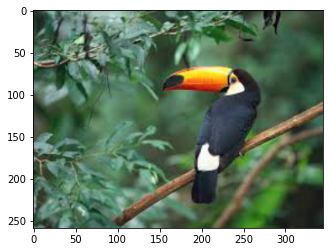

In [27]:
print("Content Image")
showImage(content)

Style Image


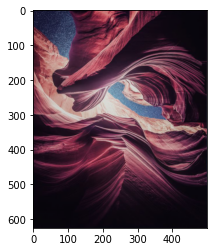

In [28]:
print("Style Image")
showImage(style)

In [31]:
def get_features(image,model):
  layers = {
      # Style Feature
      '0':'conv1_1',
      '5':'conv2_1',
      '10': 'conv3_1',
      '19':'conv4_1',
      '28':'conv5_1',
      # Content Feature
      '21':'conv4_2'
  }
  features = {}
  x = image
  for name,layer in model._modules.items():

    x = layer(x) 
    if name in layers:
      features[layers[name]] = x

  return features

In [37]:
content_f = get_features(content,vgg)
style_f = get_features(style,vgg)

In [39]:
def gram_matrix(image_tensor):
  b,c,h,w = image_tensor.shape
  image = image_tensor.view(c,h*w)
  gram = torch.mm(image,image.t())
  return gram

In [40]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

In [43]:
print(style_grams.keys())

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])


In [44]:
# Content Loss is calculated between Target Conv4_2 and Content Conv 4_2

def content_loss(target_conv4_2,content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [48]:
style_weights = {
    'conv1_1' : 1.0,
    'conv2_1' : 0.75,
    'conv3_1' : 0.2,
    'conv4_1' : 0.2,
    'conv5_1' : 0.2
}

In [45]:
# Style Loss is calculated between Style Gram and Target Gram
def style_loss(style_weights,target_features,style_grams):
  loss = 0
  for layer in style_weights:
    target_f = target_features[layer]
    target_gram = gram_matrix(target_f)
    style_gram = style_grams[layer]
    b,c,h,w = target_f.shape
    layer_loss = style_weights[layer] * torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)
  return loss

In [50]:
target = content.clone().requires_grad_(True).to(device)
target_f = get_features(target,vgg)
print("Content Loss :",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss :",style_loss(style_weights,target_f,style_grams))

Content Loss : tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss : tensor(1790.8409, device='cuda:0', grad_fn=<AddBackward0>)


In [51]:
from torch import optim
optimizer = optim.Adam([target], lr = 0.003)
alpha = 1
beta = 1e5

epochs = 3000
show_every = 500

In [52]:
def total_loss(c_loss,s_loss,alpha,beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

Total loss at Epoch 0 : 178333968.0


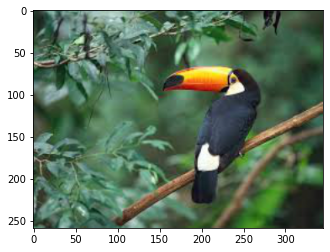

Total loss at Epoch 500 : 27049130.0


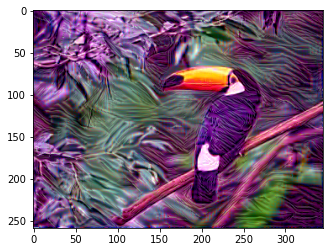

Total loss at Epoch 1000 : 15131443.0


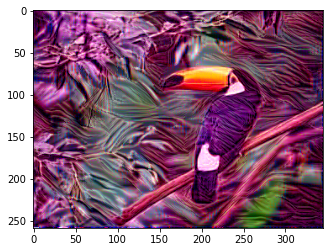

Total loss at Epoch 1500 : 11677004.0


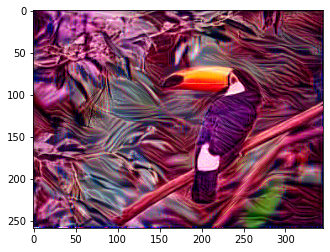

Total loss at Epoch 2000 : 9624885.0


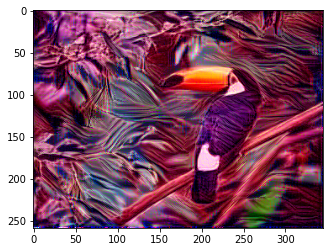

Total loss at Epoch 2500 : 8219518.0


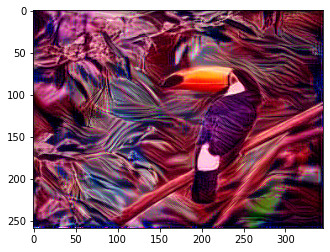

In [54]:
loss = []
for epoch in range(epochs):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss = style_loss(style_weights,target_f,style_grams)
  t_loss = total_loss(c_loss,s_loss,alpha,beta)
  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()
  loss.append(t_loss)
  if epoch%show_every == 0:
    print("Total loss at Epoch {} : {}".format(epoch,t_loss))
    showImage(target.detach())

Final Target Image with Style added to it:


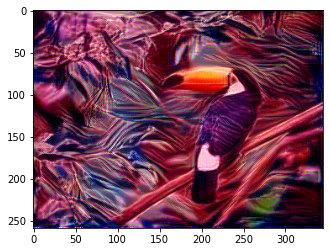

In [55]:
print("Final Target Image with Style added to it:")
showImage(target.detach())